In [1]:
import pandas as pd
from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
import re  
import en_core_web_sm
import nltk  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy import stats
from scipy.stats import normaltest
import warnings

stop_words = stopwords.words('english')
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

# P1

Construct a predictive model for the continues data recorded in the following CSV file. Document and explain your solution and approach.

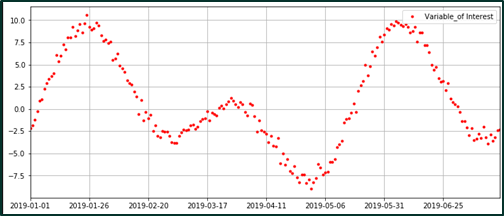

In [2]:
# function to test a dataset for stationary (from kaggle)
def test_stationarity(timeseries, window = 12, cutoff = 0.01):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# function to evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

### Data Exploration and Prep

Continuous time series data with no visible outliers. 

Data prep:

- check for missing dates
- convert to datetime
- check for missing data
- remove "value:" and convert the target to a quantity

In [3]:
p1_raw_data = pd.read_excel('P1.xlsx')
p1_raw_data.head()

,DATE,Variable_of Interest
0,2019-01-01,value: -2.13
1,2019-01-02,value: -1.84
2,2019-01-03,value: -1.19
3,2019-01-04,value: -0.28
4,2019-01-05,value: 0.93


In [4]:
p1_raw_data.tail()

,DATE,Variable_of Interest
195,2019-07-15,value: -2.87
196,2019-07-16,value: -3.55
197,2019-07-17,value: -3.18
198,2019-07-18,value: -2.37
199,2019-07-19,value: -2.32


In [ ]:
# check to see if there are any missing dates between the head and tail we just looked at
p1_raw_data['DATE'] = pd.to_datetime(p1_raw_data['DATE'])
len(list(pd.date_range(start = '2019-01-01', end = '2019-07-19' ).difference(p1_raw_data['DATE'])))

0

In [ ]:
# strip the text from the data to leave just the quantities
p1_raw_data['Variable_of Interest'] = p1_raw_data['Variable_of Interest'].map(lambda x: x.lstrip('value: ')).astype(float)
p1_raw_data.head()

,DATE,Variable_of Interest
0,2019-01-01,-2.13
1,2019-01-02,-1.84
2,2019-01-03,-1.19
3,2019-01-04,-0.28
4,2019-01-05,0.93


In [ ]:
p1_raw_data = p1_raw_data.set_index('DATE', drop = True)
p1_raw_data.head()

,Variable_of Interest
DATE,
2019-01-01,-2.13
2019-01-02,-1.84
2019-01-03,-1.19
2019-01-04,-0.28
2019-01-05,0.93


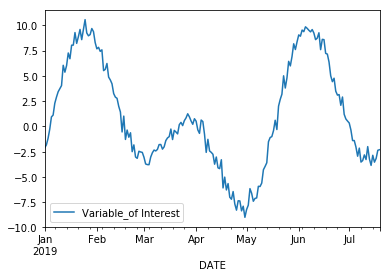

In [ ]:
# sanity check that data looks the same
p1_raw_data.plot()
plt.show()

### ARIMA

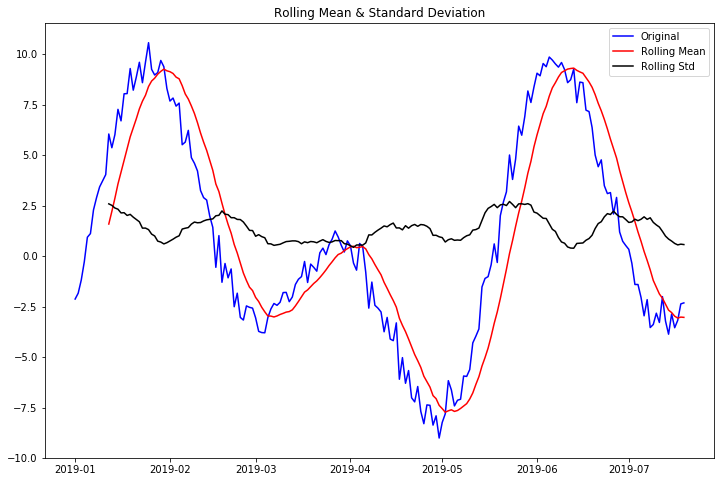

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -5.185360
p-value                          0.000009
#Lags Used                      10.000000
Number of Observations Used    189.000000
Critical Value (1%)             -3.465431
Critical Value (5%)             -2.876957
Critical Value (10%)            -2.574988
dtype: float64


In [ ]:
# Determine if the series is stationary using Dickey-Fuller Test
test_stationarity(p1_raw_data['Variable_of Interest'])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


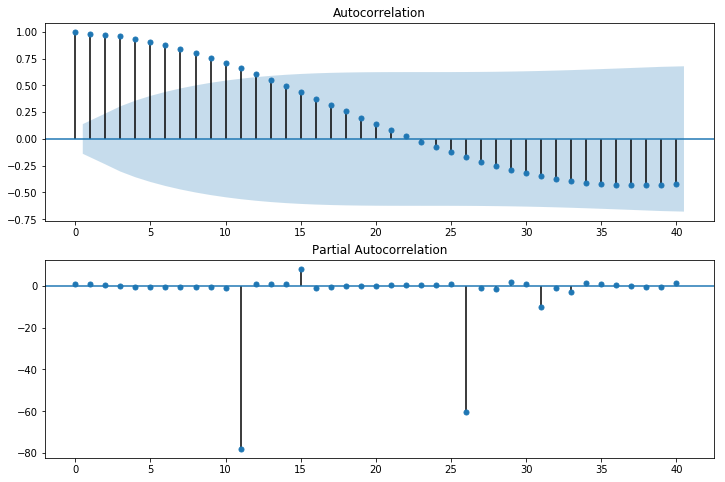

In [ ]:
# check the AC and PAC charts to try and get initial estimates on the ARIMA variables
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(p1_raw_data['Variable_of Interest'], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(p1_raw_data['Variable_of Interest'], lags = 40, ax=ax2)

### Use initial estimates of p,d,q parameters to perform a grid search and minimize MSE

In [ ]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10, 12]
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")

# test/train split in the function
# results in  next cell, blocked out due to run speed
evaluate_models(p1_raw_data['Variable_of Interest'], p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=32.276
ARIMA(0, 0, 1) MSE=9.653
ARIMA(0, 0, 2) MSE=6.010
ARIMA(0, 1, 0) MSE=0.612
ARIMA(0, 1, 1) MSE=0.603
ARIMA(0, 1, 2) MSE=0.525
ARIMA(0, 1, 3) MSE=0.464
ARIMA(0, 2, 0) MSE=1.433
ARIMA(0, 2, 1) MSE=0.598
ARIMA(0, 2, 2) MSE=0.487
ARIMA(0, 2, 3) MSE=0.498
ARIMA(1, 0, 0) MSE=0.585
ARIMA(1, 1, 0) MSE=0.599
ARIMA(1, 1, 1) MSE=0.578
ARIMA(1, 1, 2) MSE=0.477
ARIMA(1, 1, 3) MSE=0.490
ARIMA(1, 2, 0) MSE=0.854
ARIMA(1, 2, 3) MSE=0.379
ARIMA(2, 0, 0) MSE=0.566
ARIMA(2, 0, 2) MSE=0.383
ARIMA(2, 0, 3) MSE=0.374
ARIMA(2, 1, 0) MSE=0.592
ARIMA(2, 1, 2) MSE=0.507
ARIMA(2, 1, 3) MSE=0.334
ARIMA(2, 2, 0) MSE=0.428
ARIMA(2, 2, 1) MSE=0.417
ARIMA(2, 2, 3) MSE=0.515
ARIMA(4, 0, 0) MSE=0.387
ARIMA(4, 1, 0) MSE=0.407
ARIMA(4, 2, 0) MSE=0.420
ARIMA(4, 2, 1) MSE=0.439
ARIMA(4, 2, 2) MSE=0.357
ARIMA(4, 2, 3) MSE=0.346
ARIMA(6, 0, 0) MSE=0.366
ARIMA(6, 0, 1) MSE=0.352
ARIMA(6, 1, 0) MSE=0.413
ARIMA(6, 1, 1) MSE=0.432
ARIMA(6, 2, 0) MSE=0.430
ARIMA(6, 2, 1) MSE=0.444
ARIMA(8, 0, 1) MSE=0.360

- ARIMA(0, 0, 0) MSE=32.276
- ARIMA(0, 0, 1) MSE=9.653
- ARIMA(0, 0, 2) MSE=6.010
- ARIMA(0, 1, 0) MSE=0.612
- ARIMA(0, 1, 1) MSE=0.603
- ARIMA(0, 1, 2) MSE=0.525
- ARIMA(0, 2, 0) MSE=1.433
- ARIMA(0, 2, 1) MSE=0.598
- ARIMA(0, 2, 2) MSE=0.487
- ARIMA(1, 0, 0) MSE=0.585
- ARIMA(1, 1, 0) MSE=0.599
- ARIMA(1, 1, 1) MSE=0.578
- ARIMA(1, 1, 2) MSE=0.477
- ARIMA(1, 2, 0) MSE=0.854
- ARIMA(2, 0, 0) MSE=0.566
- ARIMA(2, 0, 2) MSE=0.383
- ARIMA(2, 1, 0) MSE=0.592
- ARIMA(2, 1, 2) MSE=0.507
- ARIMA(2, 2, 0) MSE=0.428
- ARIMA(2, 2, 1) MSE=0.417
- ARIMA(4, 0, 0) MSE=0.387
- ARIMA(4, 1, 0) MSE=0.407
- ARIMA(4, 2, 0) MSE=0.420
- ARIMA(4, 2, 1) MSE=0.439
- ARIMA(4, 2, 2) MSE=0.357
- ARIMA(6, 0, 0) MSE=0.366
- ARIMA(6, 0, 1) MSE=0.352
- ARIMA(6, 1, 0) MSE=0.413
- ARIMA(6, 1, 1) MSE=0.432
- ARIMA(6, 2, 0) MSE=0.430
- ARIMA(6, 2, 1) MSE=0.444
- ARIMA(8, 0, 1) MSE=0.360
- ARIMA(8, 1, 0) MSE=0.440
- ARIMA(8, 1, 1) MSE=0.439
- ARIMA(8, 1, 2) MSE=0.440
- ARIMA(8, 2, 0) MSE=0.450
- ARIMA(10, 0, 1) MSE=0.368
- ARIMA(10, 0, 2) MSE=0.337
- ARIMA(10, 1, 0) MSE=0.443
- ARIMA(10, 1, 1) MSE=0.458
- ARIMA(10, 1, 2) MSE=0.414
- ARIMA(10, 2, 0) MSE=0.451
- ARIMA(10, 2, 1) MSE=0.442
- Best ARIMA(10, 0, 2) MSE=0.337

In [ ]:
# create an ARIMA model using the best parameters from the grid serach
arima_mod = sm.tsa.ARIMA(p1_raw_data['Variable_of Interest'], (10, 0, 2)).fit(disp=False)
print(arima_mod.summary())

In [ ]:
# check to see if residuals are a normal distribution
resid = arima_mod.resid
print(normaltest(resid))
fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0)

# get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

# plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

# AC and PAC
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod.resid, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod.resid, lags=20, ax=ax2)

In [ ]:
# next time step forcast
arima_mod.forecast()[0]

#### Summary and Results:
- ARIMA(10, 0, 2) arrived at by minimizing the MSE
- Resulting ARIMA model residuals have a good, normal distribution
- Validated using the last 25% of the data with an MSE = 0.337

#### Next Steps:
- Create a predictor:
    - Turn preprocessing into a function to ensure "apples to apples" predictions
    - Use the built in predict() or forecast() functions to forecast future data
- seasonal in 06-2019
- 10th order AR overfitting?

# P2

Problem No.2 (Modified from https://www.kaggle.com/)

Construct a binary classifier for historical data of patients who were diagnosed (or ruled out) from a heart disease. The data contains thirteen features and a target columns as follows:

1. age      - age in years
2. sex      - (male; female)
3. cp       - chest pain type
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)
5. chol     - serum cholesterol in mg/dl
6. fbs      - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
7. restecg  - resting electrocardiographic results
8. thalach  - maximum heart rate achieved
9. exang    - exercise induced angina (1 = yes; 0 = no)
10. oldpeak  - ST depression induced by exercise relative to rest
11. slope    - the slope of the peak exercise ST segment
12. ca       - number of major vessels (0-3) colored by fluoroscopy
13. thal     - 3 = normal; 6 = fixed defect; 7 = reversable defect
14. target   - have disease or not

In [ ]:
# function to label encode categorical columns in a df
def categorize_df(dataframe, cols):
    le = preprocessing.LabelEncoder()
    for col in cols:
        dataframe[col] = le.fit_transform(dataframe[col])
    return dataframe

# function to normalize numerical columns in a df
def normalize_df(dataframe, cols):
    dataframe[cols] = preprocessing.normalize(dataframe[cols])
    return dataframe

# function to print an sklearn classification report
def print_results(y_test, y_predict, cols):
    plot_confusion_matrix(y_test, y_predict, cols)
    print('\n')
    print("=== Classification Report ===")
    print(classification_report(y_test, y_predict))
    print('\n')
    
# function to create a confusion matrix for cotegorical predictions
def plot_confusion_matrix(y_true, y_pred, cols, cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=cols, yticklabels=cols,
           # ... and label them with the respective list entries
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax

def strat_k_folds(model_skfold,X, y):
    skfold = model_selection.StratifiedKFold(n_splits = 4)
    results_skfold = model_selection.cross_val_score(model_skfold, X, y, cv=skfold)
    return results_skfold.mean()

def plot_trend(n, mean_acc, x_title):
    plt.plot(range(1,n),mean_acc,'g')
    plt.ylabel('Accuracy ')
    plt.xlabel(x_title)
    plt.tight_layout()
    plt.show()

### Data Exploration and Prep

- need to transpose the data on import
- Check data types for each column in case everything imported as text
- Check for whitespace and capitalization
- check for missing data
    - if small compared to sample size then remove
- Check for outliers in numerical data
    - if small compared to sample size then remove
- Check for data balance in "Disease" and "No Disease" categories
    - use over/under sampling if necessary
- check the independance of the variables


In [ ]:
# inverse data on import
p2_raw_data = pd.read_excel('P2.xlsx', index_col=0, header=None).T
p2_raw_data.head()

In [ ]:
# check the data types
p2_raw_data = p2_raw_data.drop(p2_raw_data.columns[0], axis=1)
p2_raw_data.dtypes

In [ ]:
# Check if 'slope' is a categorical column
p2_raw_data['slope'].value_counts()

In [ ]:
p2_raw_data['target'] = p2_raw_data['target'].replace('Disease', 1).replace('No disease', 0)
p2_raw_data['target'].value_counts()

In [ ]:
# check for missing data 
p2_raw_data.isna().sum()

In [ ]:
# Only three missing data points so just remove
p2_raw_data = p2_raw_data.dropna()

In [ ]:
# convert numerical columns to type 'float' and convert all categorical columns to upper case
numerical_columns = ['age','trestbps','chol','thalach','oldpeak',]
categorical_columns = ['sex','cp','fbs','restecg','exang','slope','ca','thal','target']

for n_col in numerical_columns:
    p2_raw_data[n_col] = p2_raw_data[n_col].astype('float')

for c_col in categorical_columns:
    p2_raw_data[c_col] = p2_raw_data[c_col].astype('str').str.upper()

In [ ]:
# normalize the numerical columns and encode the categorical columns
p2_raw_data = categorize_df(p2_raw_data,categorical_columns)
p2_raw_data = normalize_df(p2_raw_data,numerical_columns)
p2_raw_data.head()

In [ ]:
# identify outliers
boxplot = p2_raw_data.boxplot(column = numerical_columns,figsize = (6,12))

In [ ]:
# brute force drop of outliers - normally done non-visually
for i in range(2):
    p2_raw_data = p2_raw_data.drop(p2_raw_data['age'].idxmax())

p2_raw_data = p2_raw_data.drop(p2_raw_data['trestbps'].idxmax())
p2_raw_data = p2_raw_data.drop(p2_raw_data['trestbps'].idxmin())

for i in range(2):
    p2_raw_data = p2_raw_data.drop(p2_raw_data['chol'].idxmin())

for i in range(4):
    p2_raw_data = p2_raw_data.drop(p2_raw_data['oldpeak'].idxmax())

In [ ]:
# check the independance of the variables
pearsoncorr = p2_raw_data.corr(method='pearson')

fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

In [ ]:
# separate the variables from the target and divide into training and test sets
X = p2_raw_data.copy()
y = X.pop('target').astype('int')
x_col = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .7)
headers = ['No Disease','Disease']  

### Classifiers

-not using full hyperparameter searches
- Logistic Regression with search for solver and c parameters (sequential)
- SVC with search for kernal parameter
- Random Forest  with search for max_depth and max_features parameters (sequential)

### Logistic Regression

In [ ]:
solv = ['newton-cg','lbfgs','liblinear']
temp_acc_lr = 0
temp_max_lr = ''
for s in solv:
    LR = LogisticRegression(C=0.25, solver=str(s))
    acc = strat_k_folds(LR, X, y)
    if acc > temp_acc_lr:
        temp_acc_lr = acc
        temp_max_lr = s
print("The best accuracy was ", temp_acc_lr, "with solver = ", temp_max_lr, '\n') 

c_test = [.01,.05,.1,.15,.2,.25,.3,.35,.4,.45,.5]
mean_acc_lr = np.zeros((len(c_test)-1))
for c in range(len(c_test)):
    LR = LogisticRegression(C = c_test[c], solver = str(temp_max_lr))
    mean_acc_lr[c-1] = strat_k_folds(LR, X, y)
    
best_c = c_test[mean_acc_lr.argmax()+1]
print( "The best accuracy was ", mean_acc_lr.max(), "with c = ", best_c, '\n')

log_reg = LogisticRegression(C = best_c, solver=str(temp_max_lr))
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_pred_lr_acc = accuracy_score(y_test, y_pred_lr)
print('\n', 'Logistic regression accuracy_score: ', y_pred_lr_acc,'\n')

print_results(y_test, y_pred_lr, headers)
table = log_reg.predict_proba(X_test)
prediction_proba_lr = pd.DataFrame(table, columns = headers)

### SVC

In [ ]:
# hyperparameter search for best kernal
kern = ['linear','poly','rbf','sigmoid']

temp_acc_svm = 0
temp_max_svm = ''
for k in kern:
    svc_clf = SVC(kernel=str(k),gamma='scale')
    acc = strat_k_folds(svc_clf, X, y)
    if acc > temp_acc_svm:
        temp_acc_svm = acc
        temp_max_svm = k
        
print("The best accuracy was ", temp_acc_svm, "with kernel = ", temp_max_svm, '\n')


classifier_svc = SVC(kernel=str(temp_max_svm),gamma='scale')
classifier_svc.fit(X_train, y_train)

y_pred_svc = classifier_svc.predict(X_test)
y_pred_svc_acc = accuracy_score(y_test, y_pred_svc)
print('\n', 'SVC accuracy_score: ', y_pred_svc_acc,'\n')

print_results(y_test, y_pred_svc, headers)

### Random Forest

In [ ]:
feat = 10
mean_acc_dt = np.zeros((feat-1))

for n_feat in range(1,feat):
    #Train Model and Predict  
    clf_rf = RandomForestClassifier(n_estimators = 300, criterion="entropy", max_features = n_feat)
    mean_acc_dt[n_feat-1] = strat_k_folds(clf_rf, X, y) 

plot_trend(feat, mean_acc_dt, 'Max Number of Features')
best_feat = mean_acc_dt.argmax()+1
print( "The best accuracy was ", mean_acc_dt.max(), "with max_features = ", best_feat, '\n')

dep = 15
mean_acc_dt = np.zeros((dep-1))

for n_dep in range(1,dep):
    #Train Model and Predict  
    clf_rf = RandomForestClassifier(n_estimators = 300, criterion="entropy", max_features = best_feat, max_depth = n_dep)
    mean_acc_dt[n_dep-1] = strat_k_folds(clf_rf, X, y) 

plot_trend(dep, mean_acc_dt, 'Max Tree Depth')
best_dep = mean_acc_dt.argmax()+1
print( 'The best accuracy was ', mean_acc_dt.max(),'with max_depth = ', best_dep, 'and max_features = ', best_feat,'\n')

# Random Forest
classifier_rf = RandomForestClassifier(n_estimators = 300, criterion="entropy", max_features = best_feat, max_depth = best_dep)
classifier_rf.fit(X_train, y_train)


y_pred = classifier_rf.predict(X_test)
y_pred_rf_acc = accuracy_score(y_test, y_pred)
print('\n', 'RF accuracy_score: ', y_pred_rf_acc,'\n')
for feat, importance in zip(x_col, classifier_rf.feature_importances_):
    print('%-25s : %20f' % (feat, importance))

print_results(y_test, y_pred, headers)
table = log_reg.predict_proba(X_test)
prediction_proba_rf = pd.DataFrame(table, columns = headers)

In [ ]:
# Choose between LR and RF for confidence testing:
if y_pred_lr_acc > y_pred_rf_acc:
    y_pred_proba = prediction_proba_lr.iloc[:,-1]
    proba_list = list(prediction_proba_lr['Disease'])
    print('The most accurate model is logistic regression with an accuracy of:', y_pred_lr_acc)
else:
    y_pred_proba = prediction_proba_rf.iloc[:,-1]
    proba_list = list(prediction_proba_rf['Disease'])
    print('The most accurate model is a random forest with an accuracy of:', y_pred_rf_acc)


In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="has disease, AUC = "+str(auc))
plt.legend(loc=4)

plt.plot(range(2),linestyle = '--')
plt.xlabel("False Positive Rate - specificity")
plt.ylabel("True Positive Rate - sensitivity")

plt.show()

In [ ]:
counts, bins = np.histogram(y_pred_proba)
plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
X_test['Disease'] = proba_list
        
proba_list = [round(num) for num in proba_list]
X_test['predicted_result'] = proba_list

result_list = list(y_test)
X_test['actual_result'] = result_list

X_test['logic'] = np.where(X_test['actual_result'] == X_test['predicted_result'], 1, 0) 

X_test['TP'] = np.where((X_test['actual_result'] == 1) & (X_test['predicted_result'] == 1), 1, 0) 
X_test['FP'] = np.where((X_test['actual_result'] == 0) & (X_test['predicted_result'] == 1), 1, 0) 
X_test['TN'] = np.where((X_test['actual_result'] == 0) & (X_test['predicted_result'] == 0), 1, 0) 
X_test['FN'] = np.where((X_test['actual_result'] == 1) & (X_test['predicted_result'] == 0), 1, 0) 



print(X_test[['Disease','actual_result','logic','TP','FP','TN','FN']])

In [ ]:
for x in range(50, 101, 5):
    X_test_temp = X_test[(X_test['Disease'] > x/100)|(X_test['Disease'] < (1-x/100))]
    # change to df to look better if there is time
    print('%.2f : %s : %.4f : %s : %s : %s : %s' %(x/100,len(X_test_temp),X_test_temp['logic'].mean(),X_test_temp['TP'].sum(),X_test_temp['FP'].sum(),X_test_temp['TN'].sum(),X_test_temp['FN'].sum()))

#### Summary and Results:

- The Random Forest model provided the best accuracy with a score of 0.885
    - max_features = 2, max_depth = 4, trees = 300
- Validated using 30% of the initial data set
    - AUC approximately equal to 0.92
    - F1 approximately 0.85

#### Discussion
For this particular problem, predicting whether someone has a disease, the main diagnosis to avoid would be a false negative, telling someone they are fine when they are not. In light of this, choosing an acceptable false positive rate and then operating within the confidence interval to achieve it will be very important during selection of operating parameters. For example, at a confidence interval of 70% in the above example, we not longer have any false negatives. People who are not within the interval will simply get an "inconclusive". Additionally, models that do not offer a probability in the predictin (SVC) my not be able to be used.

#### Next Steps:
- Check results in removing highly correlated data
    - thalach and chol with at -0.82
    - chol and tresbps with at -0.67
- More thorough grid serach to determice hyperparameters
- Create a predictor:
    - Turn preprocessing into a function to ensure "apples to apples" predictions
    - Use the built in predict() functions to analyze new patients for risk
- Get more data - large number of parameters for this many samples (partner with other organizations to standardize and combine data)
- Odd probability distribution, check for information leakage in the data being passed to the model

# P3

Imagine you’re advising a store manager who oversees the home & kitchen department and you are given a customer review data. What insights can you drive from this data which will help improve the business?

Data prep:
- Check if ID is based on user or review (can we draw any individual user conclusions)
- Drop reviews with no text
- Prep review text:
    - Change to all lowercase
    - Remove all the special characters and numbers
    - Lemmatize and stem each word
    - Remove short words (length < 3)
    - Remove stopwords from the text
- Check DATE for format datetime for time analysis

Ideas:
- Time analysis of scores and total ratings
- Analyze text from the good scores (5) and bad scores (1, 2) separately to try and draw conclusions about general content using bigrams
- Use LDA to group the reviews and look at the top words from each group to try and for drawing conclusions

In [ ]:
# function to reduce words in a text block to the stem
def stem_sentences(text):
    stemmer = WordNetLemmatizer()
    tokens = text.split()
    stemmed = [stemmer.lemmatize(token) for token in tokens]
    return ' '.join(stemmed)

# function to remove stop words (common words)
def remove_stopwords(text):
    text_new = " ".join([i for i in text if i not in stop_words])
    return text_new

# function to filter for nouns and adjectives 
def lemmatization(texts, tags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

In [ ]:
p3_raw_data = pd.read_excel('P3.xlsx')
p3_raw_data.head()

In [ ]:
# what % of the ID's are unique - review ID or user ID?
len(p3_raw_data['ID'].unique())/len(p3_raw_data)

In [ ]:
# set ID as the index for future analysis and rename columns
p3_raw_data = p3_raw_data.set_index(['ID'])
p3_raw_data = p3_raw_data.rename(columns={'Customer Rating (5-Best, 1-Worst)': 'cust_rating', 'Review Text': 'review_text', 'Review Date':'review_date'})
p3_raw_data.dtypes

In [ ]:
# check for missing reviews
p3_raw_data.isna().sum()

In [ ]:
# 3/5000 reviews missing so just drop them
p3_raw_data = p3_raw_data.dropna()

In [ ]:
# convert review_date to a datetime format
p3_raw_data['review_date'] = pd.to_datetime(p3_raw_data['review_date'])
p3_raw_data['review_date'].head()

### Text Prep

In [ ]:
# Change to all lowercase
p3_raw_data['review_text'] = p3_raw_data['review_text'].str.lower()
# Remove all the special characters and numbers
p3_raw_data['review_text'] = p3_raw_data['review_text'].str.replace("[^a-zA-Z#]", " ")
# Lemmatize and stem each word
p3_raw_data['review_text'] = p3_raw_data['review_text'].map(lambda x: stem_sentences(x))
# Remove short words (length < 3)
p3_raw_data['review_text'] = p3_raw_data['review_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
# Remove stopwords from the text
p3_raw_data['review_text'] = [remove_stopwords(r.split()) for r in p3_raw_data['review_text']]

p3_raw_data.head()

In [ ]:
# new columns for grouping
p3_raw_data['review_year'] = p3_raw_data['review_date'].dt.year
p3_raw_data['review_month'] = p3_raw_data['review_date'].dt.month
p3_raw_data[['review_date','review_year','review_month']].head()

### Yearly/Monthly Analysis of Review Count and Rating

In [ ]:
ax = p3_raw_data['cust_rating'].value_counts().plot(kind='bar',title='Review Count')
ax.set_xlabel('Review Score')
ax.set_ylabel('Count')
plt.show()
print('Overall customer rating average: %.2f' % (p3_raw_data['cust_rating'].mean()))

In [ ]:
# Look at the monthly trend
fig = plt.figure(figsize=(20,5)) # not working correctly?
p3_raw_data_monthly_ave = p3_raw_data.groupby(by=[p3_raw_data['review_year'], p3_raw_data['review_month']]).mean()
p3_raw_data_monthly_ave.plot()
plt.title('Average Monthly Rating')
plt.show()

In [ ]:
# Look at the yearly trend
fig = plt.figure(figsize=(20,5)) # not working correctly?
p3_raw_data_yearly_ave = p3_raw_data.groupby(by=[p3_raw_data['review_year']]).mean()
p3_raw_data_yearly_ave = p3_raw_data_yearly_ave.drop(columns = ['review_month'])
p3_raw_data_yearly_ave.plot()
plt.title('Average Yearly Rating')
plt.show()

In [ ]:
# Look at the monthly trend
fig = plt.figure(figsize=(20,5))
p3_raw_data_monthly_cnt = p3_raw_data.groupby(['review_year','review_month'])['review_text'].count()
p3_raw_data_monthly_cnt.plot()
plt.title('Monthly Rating Count')
plt.show()

In [ ]:
# 2014 dip? assume that the number of reviews it representative of the number of purchases?
p3_raw_data_monthly_cnt

In [ ]:
# Look at the yearly trend
fig= plt.figure(figsize=(20,5))
p3_raw_data_yearly_cnt = p3_raw_data.groupby(['review_year'])['review_text'].count()
p3_raw_data_yearly_cnt.plot()
plt.title('Yearly Rating Count')
plt.show()

In [ ]:
#count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
#doc_term_matrix = count_vect.fit_transform(p3_raw_data['review_text'].values.astype('U'))

tfidfconverter = TfidfVectorizer(min_df=5, max_df=0.6, stop_words=stopwords.words('english')) 

p3_raw_data_bad = p3_raw_data[p3_raw_data['cust_rating'] <= 2]
p3_raw_data_good = p3_raw_data[p3_raw_data['cust_rating'] == 5]

print('total count: ', len(p3_raw_data))

print('1 and 2 review count: ', len(p3_raw_data_bad))
print('5-review count: ', len(p3_raw_data_good))

### Bi-grams for good reviews

In [ ]:
# Getting bigrams  
vectorizer_2 = CountVectorizer(ngram_range =(3, 3)) 
X1_2 = vectorizer_2.fit_transform(p3_raw_data_good['review_text'])  
features_2 = (vectorizer_2.get_feature_names()) 

# TFIDF 
vectorizer_2 = TfidfVectorizer(max_df = 0.8, stop_words=stopwords.words('english'), ngram_range = (3, 3)) 
X2_2 = vectorizer_2.fit_transform(p3_raw_data_good['review_text']) 
scores_2 = (X2_2.toarray()) 
  
# Getting top ranking features 
sums_2 = X2_2.sum(axis = 0) 
data1_2 = [] 
for col, term in enumerate(features_2): 
    data1_2.append( (term, sums_2[0, col] )) 
ranking_2 = pd.DataFrame(data1_2, columns = ['term', 'rank']) 
words_2 = (ranking_2.sort_values('rank', ascending = False)) 
print ("\n\nWords : \n", words_2.head(20))

### Bi-grams for bad reviews

In [ ]:
# Getting bigrams  
vectorizer = CountVectorizer(ngram_range =(3, 3)) 
X1 = vectorizer.fit_transform(p3_raw_data_bad['review_text'])  
features = (vectorizer.get_feature_names()) 

# TFIDF 
vectorizer = TfidfVectorizer(max_df = 0.8, stop_words=stopwords.words('english'), ngram_range = (3, 3)) 
X2 = vectorizer.fit_transform(p3_raw_data_bad['review_text']) 
scores = (X2.toarray()) 
  
# Getting top ranking features 
sums = X2.sum(axis = 0) 
data1 = [] 
for col, term in enumerate(features): 
    data1.append( (term, sums[0, col] )) 
ranking = pd.DataFrame(data1, columns = ['term', 'rank']) 
words = (ranking.sort_values('rank', ascending = False)) 
print ("\n\nWords : \n", words.head(20))

### LDA

In [ ]:
# convert using tfidf - a combination of word frequency and inverse document frequency
doc_term_matrix_bad = tfidfconverter.fit_transform(p3_raw_data_bad['review_text'].values.astype('U'))
doc_term_matrix_good = tfidfconverter.fit_transform(p3_raw_data_good['review_text'].values.astype('U'))

### LDA for positive reviews

In [ ]:
LDA_good = LatentDirichletAllocation(n_components=10)
LDA_good.fit(doc_term_matrix_good)

In [ ]:
# print the top ten words for each grouping
for i,topic in enumerate(LDA_good.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidfconverter.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

### LDA for negative reviews

In [ ]:
LDA_bad = LatentDirichletAllocation(n_components = 10)
LDA_bad.fit(doc_term_matrix_bad)

In [ ]:
for i,topic in enumerate(LDA_bad.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidfconverter.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

#### Summary and Results:
- Customer ratings overwhelmingly positive with an overall average of 4.49
- As more reviews have come in the average has stabilized at this high standard
- The total number of reviews seemed to have exponential growth until 2014
    - Are number of reviews representative of sales? If so, why have sales dropped off so drastically in the first months of 2014
    - Exponential growth took a hit in the second half of 2013
- Bi-grams for positive reviews
    - Oxo products are very well thought of
    - ice cream makers
- Bi-grams for negative reviews
    - products: Oxo good grip, ice cream scoop, ice cube tray, apple corer divider
    - Common topics of materials used for product - flimsy, separated, etc.
- LDA for positive reviews
    - Products: potato mashers, pressure cookers, sifters/strainers, spatula/scrapers, peeler/knives, ice cream makers, lemon zesters, wisks, vaccuums
- LDA for negative reviews
    - Products: corkscrews, baskets
    - Pain points: missing deliveries, items broken upon reciept, difficulties dealing with manufacturers
- No missing rating, so we can assume any sentiment analysis would be very closly related to these scores

#### Discussion
An issue with using unsupervised learning on all the product reviews is that creating groups (an unknown number) is very difficult to interpret. If more information on the product ID or the user ID was contained, I feel as though much more meaningful insights could be found. 

Based on the analysis above, I assume that positive experiences will lead to additional purchases. So, the products most well reviewed (through bigrams and LDA) should be promoted. Similarly, products showing up consitently in the bad reviews should appear lower in search results or be removed altogether. That ebing said, all of the text analysis does not take into account the number of times a product has been purchased, which would cause it to show up in both the good and bad lists (e.g. Oxo).
The pain points identified from the negative reviews, however, are common across all products and a deeper dive into those issues could possibly lead to better packaging, delivery confirmation, etc.

#### Next Steps:
- Label the data by product ID, pain ponts, and user by either beginning to collect this information with new reviews or labeling the existing data by hand
    - product trends in number and rating
    - suggested purchases by user
    - allows for a more in depth analysis of reviews once words common to product lines are accounted for (e.g. Oxo shows up many times in the results, but may refer to several products)
- A/B testing to see if product promotion drives users towards the more highly reviewed products
- Determine the cause of dropping review count but increasing rating and check how that relates to sales?
    - new competitor
    - market trends
- Tune the model to achieve better results: tune corpus more strictly, limit included reviews by length, more thorough analysis of number of topics, tune hyperparameters, etc.    